#### Hello and thank you for taking the time to evaluate me for this position! I have organized my notebook so that the first part of the notebook are the direct answers to the questions asked. Below that I have kept an appendix of all the code I ran as well as notes I made in the form of comments.

# Data and Notebook Setup

### Installing Packages for later

In [1]:
#install.packages("e1071")   
#install.packages("gbm")                                                         #run each only once please. 
#packageLocation <- "----------------------/irr_0.80.tar.gz"                          # I have removed the file system information
#install.packages(packageLocation, type = "source")                                   # but these are the files you need. You can
#packageLocation <- "----------------------/lpSolve_5.6.15.zip"                       # get them from the CRAN archive.
#install.packages(packageLocation)


### 1) Reading in Data

In [2]:
data <- read.csv("IMA Recommendation Simulation Data.csv")

### 1a) The data has 161563 rows and 16 columns. See code below:

In [3]:
dim(data)

[1] 161563     16

### 1b) There are 8 Levels of Current Condition

In [4]:
length(levels(data$CurrentCondition))

[1] 8

# Exploratory Data Analysis

### 2a) Request ID is not unique

In [5]:
isAllUnique <- length(unique(data$request_id)) == length(data$request_id)
isAllUnique

[1] FALSE

### 2b) There is missing data. Specifically the columns order_distance, order_origin_weight, rate_norm, and est_cost_norm contain missing data. Counts can be found below.

In [6]:
vectorOfNACounts <- lapply(data, function(y) sum(is.na(y)))
data.frame(vectorOfNACounts)

X,request_id,week_id,weekday,miles,order_equipment_type,order_distance,order_num_stops,order_origin_weight,lead_days,color,origin_dat_ref,dest_dat_ref,rate_norm,est_cost_norm,CurrentCondition
0,0,0,0,0,0,4678,0,19,0,0,0,0,181,39,0


### 2c) I would consider the following pairs to be correlated:
* Miles and Normalized Estimated Cost: It would make sense that the distance an order is being shipped impacts the cost significantly.
* Normalized Rate and Normalized Estimated Cost: Given the nature of the business, in order to satisfy customers the amount they pay should reflect the amount it costs to ship things.

[1] "Here is est_cost_norm and miles"


[1] 0.7459502

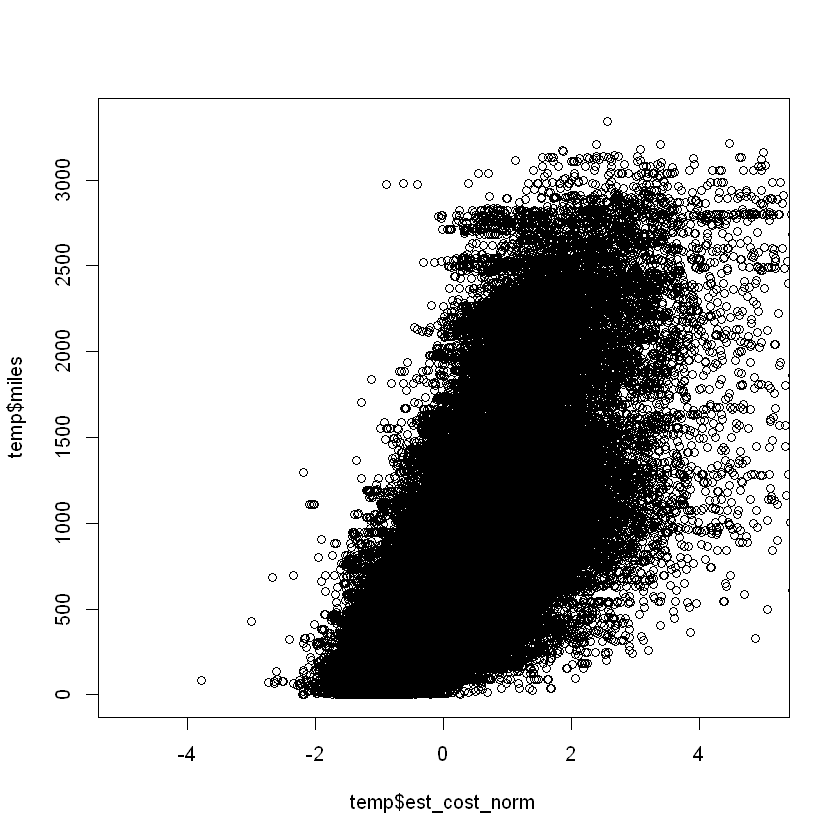

In [7]:
temp <- data
temp <- na.omit(temp)

print("Here is est_cost_norm and miles")

cor(temp$miles, temp$est_cost_norm)
plot(temp$miles~ temp$est_cost_norm, xlim = c(-5,5))

[1] "Here is est_cost_norm and rate_norm"


[1] 0.805135

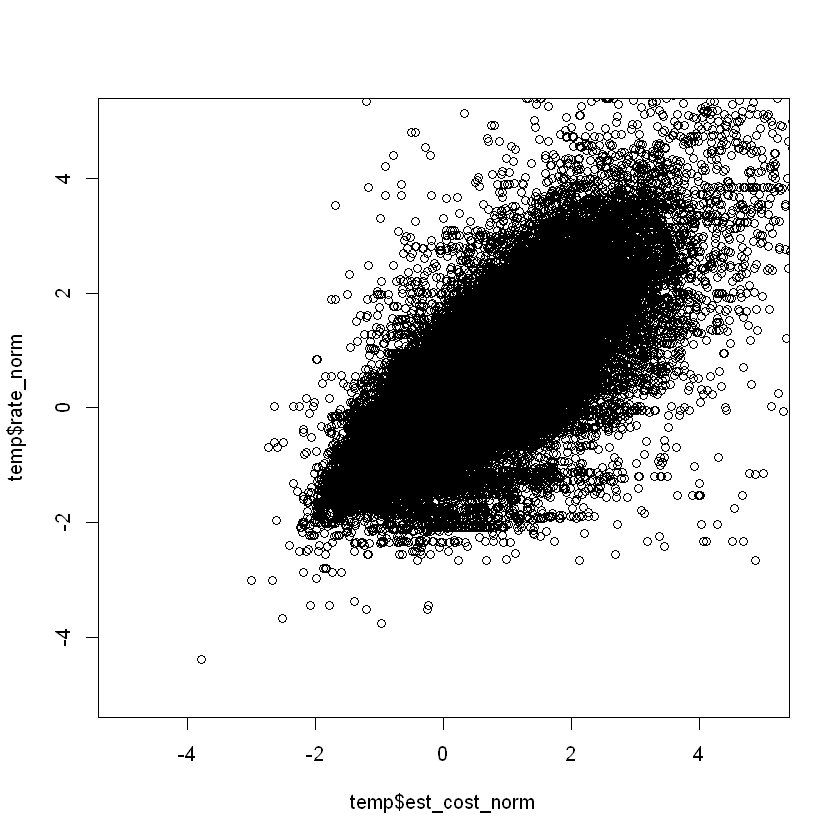

In [8]:
print("Here is est_cost_norm and rate_norm")

cor(temp$rate_norm, temp$est_cost_norm)
plot(temp$rate_norm~ temp$est_cost_norm, xlim = c(-5,5),ylim = c(-5,5))

### 2d) Here are two other visualizations I made:

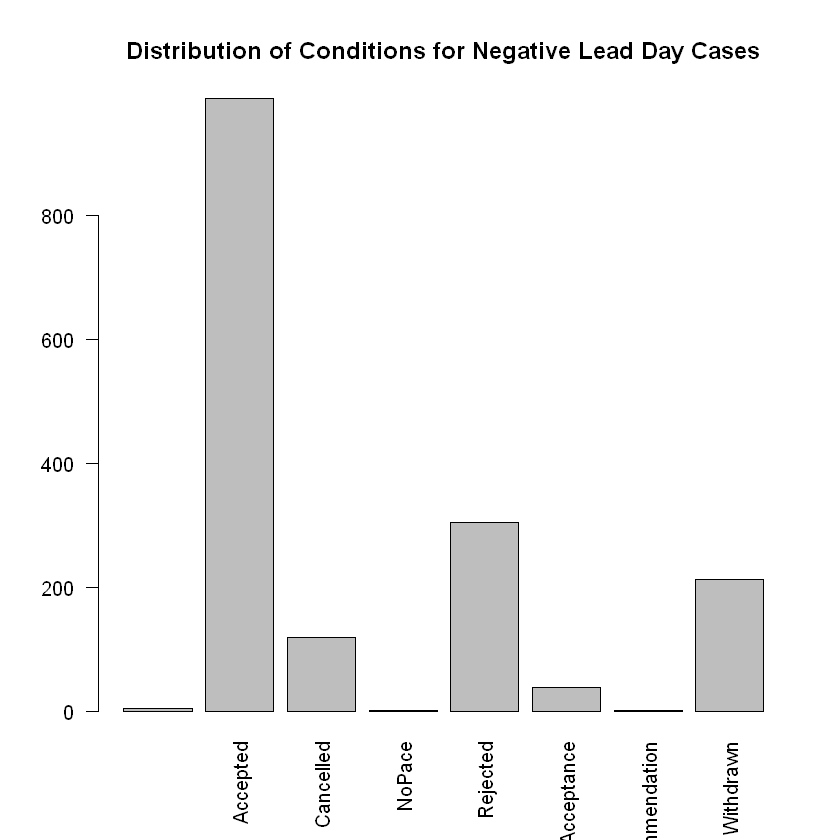

In [9]:
negativeLeadDaysSubset <- data[data$lead_days <0,]
barplot(table(negativeLeadDaysSubset$CurrentCondition),las =2, main="Distribution of Conditions for Negative Lead Day Cases")

###### When I made this chart I suspected that negative lead day cases were human errors and would have a higher rate of Canceled, Rejected, or Withdrawn cases than the rest of the data. I was also unsure whether this was a problem with the data or a specific kind of case that was documented this way. Given this this is the same rough distribution as the rest of the data, I rejected the idea that these cases were caused by human error. I did not make an assessment on the second issue.

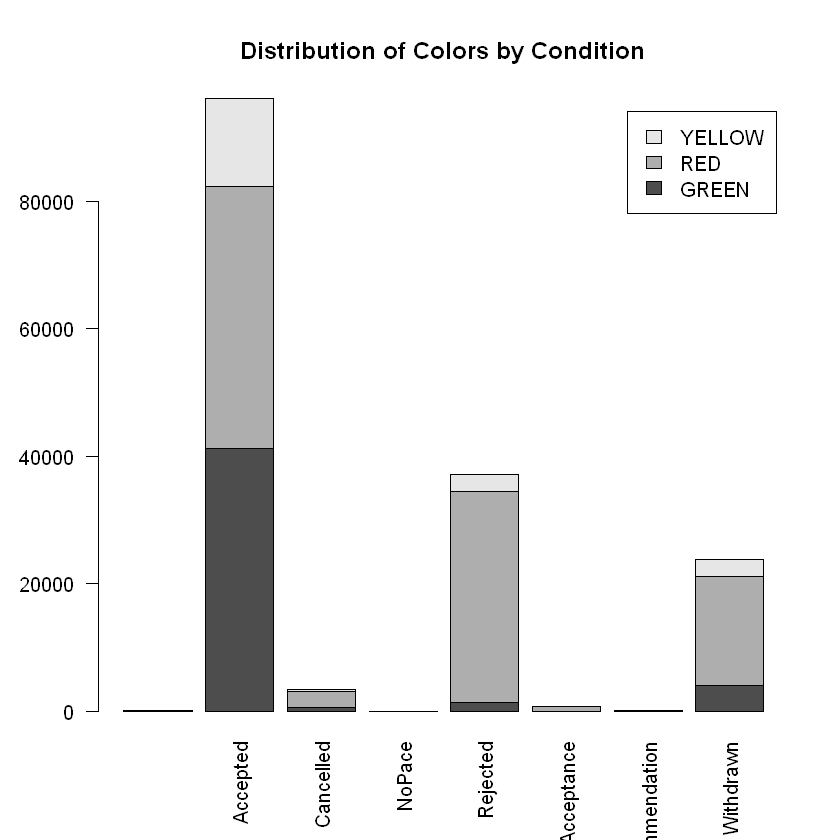

In [10]:
justColorAndCondition <- data[,c("color","CurrentCondition")]
barplot(table(justColorAndCondition),las =2, main="Distribution of Colors by Condition", legend=TRUE)

###### This graph was made because I was trying to determine the color's relationship to the current condition. I was worried that certain order statuses would have a 1:1 relationship with color (determined after the condition was known). If this was the case I would have avoided using it as part of my models because the color would be unassigned at the time of predicting. This graph shows that this is not the case and I would go on to use color in my models.

# Classification Modeling

### 3) Below is my code that creates the two train test splits that I will use to make my model. See comments below.

In [11]:
library(dplyr)
library(caret)

#This is used in my simple tree model.
dataForModel <- select(data, -request_id, -X)
dataForModel <- na.omit(dataForModel)
dataForModel <- dataForModel[-81224,]

#creating a reproducable test train split
set.seed(555)

trainIndexes <- createDataPartition(dataForModel$CurrentCondition, p=.9, list=FALSE)
trainSet <- dataForModel[trainIndexes,]
testSet <- dataForModel[-trainIndexes,]

#This is used in my gradient boosted tree model. Note that it is MUCH smaller than the previous
#subset. Ideally the models would run on identical datasets but my computer could not handle running
# the gradient boosted model with the large dataset.

set.seed(555)

#create a smaller subset
dataTemp <- select(data, -request_id, -X)
dataTemp <- dataTemp[-81224,]
dataTemp <- na.omit(dataTemp)

dataSmallIndex <- createDataPartition(dataTemp$CurrentCondition, p=.01, list=FALSE)
dataSmallTrain <- dataTemp[dataSmallIndex,]
dataSmallTest <- dataTemp[-dataSmallIndex,]



Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


### 4) Here are my two classifiers:

In [12]:
library(e1071)

trainY <- trainSet$CurrentCondition
trainX <- select(trainSet,-CurrentCondition)
trainXPredictor <- dummyVars("~ .",data=trainX)
trainXDummies <- as.data.frame(predict(trainXPredictor, newdata=trainX))

dataInput <- trainXDummies
dataInput$CurrentCondition <- as.factor(trainY)

#Create a control for the model

control <- trainControl(method="repeatedcv", number=5, repeats=3)

#-----------------------------------------------------------------------------
# Actually create the model, in this case a simple decision tree
#-----------------------------------------------------------------------------

treeMethod <- train(CurrentCondition~.,data=dataInput,method='rpart', trControl=control)
treeMethod

Warning message:
"package 'e1071' was built under R version 3.6.3"

CART 

141022 samples
    22 predictor
     8 classes: '', 'Accepted', 'Cancelled', 'NoPace', 'Rejected', 'Waiting On Acceptance', 'Waiting On Recommendation', 'Withdrawn' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 3 times) 
Summary of sample sizes: 112815, 112819, 112816, 112820, 112818, 112818, ... 
Resampling results across tuning parameters:

  cp           Accuracy   Kappa     
  0.004114865  0.6243586  0.16637405
  0.004180808  0.6240537  0.16536655
  0.022306434  0.6059574  0.05267748

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.004114865.

In [13]:
#same control
control <- trainControl(method="repeatedcv", number=5, repeats=3)

#-----------------------------------------------------------------------------
# Actually running a gradient boosted decision tree model: Note doesn't need dummy variables.
#Creating dummies is an automatic part of this particular package. See output.
#-----------------------------------------------------------------------------
library(gbm)

gradientBoosting <- train(CurrentCondition~.,data=dataSmallTrain,method='gbm', trControl=control, verbose=FALSE)
gradientBoosting

#Note: This makes many warnings because this subset does not contain the singular row that has 4 stops. Therefore the variable has
#a standard deviation of 0 across the subset. As you will see later it doesn't use the variable anyway.

Warning message:
"package 'gbm' was built under R version 3.6.3"Loaded gbm 2.1.8
Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: order_num_stops has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: order_num_stops has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: order_num_stops has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: order_num_stops has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: order_num_stops has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: order_num_stops has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, dis

Stochastic Gradient Boosting 

1571 samples
  13 predictor
   8 classes: '', 'Accepted', 'Cancelled', 'NoPace', 'Rejected', 'Waiting On Acceptance', 'Waiting On Recommendation', 'Withdrawn' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 3 times) 
Summary of sample sizes: 1256, 1257, 1256, 1256, 1259, 1258, ... 
Resampling results across tuning parameters:

  interaction.depth  n.trees  Accuracy   Kappa    
  1                   50      0.5924333  0.1121448
  1                  100      0.5981410  0.1607649
  1                  150      0.5994319  0.1741117
  2                   50      0.5926236  0.1609101
  2                  100      0.5892319  0.1729199
  2                  150      0.5932667  0.1956841
  3                   50      0.5964479  0.1811631
  3                  100      0.6006686  0.2074961
  3                  150      0.5947575  0.2070049

Tuning parameter 'shrinkage' was held constant at a value of 0.1

Tuning parameter 'n.minobsinnode' was held co

### 4a) First some context...

In [14]:
testY <- testSet$CurrentCondition
testX <- select(testSet, -CurrentCondition)
testXPredictor <- dummyVars("~ .",data=testX)
testXDummies <-as.data.frame(predict(testXPredictor, newdata=testX))
treePredictions <- predict(treeMethod,testXDummies)

library(irr)
kappa2(cbind(testY,treePredictions))

Warning message:
"package 'irr' was built under R version 4.0.3"Loading required package: lpSolve
Warning message:
"package 'lpSolve' was built under R version 4.2.0"

 Cohen's Kappa for 2 Raters (Weights: unweighted)

 Subjects = 15664 
   Raters = 2 
    Kappa = 0.194 

        z = 38.1 
  p-value = 0 

In [15]:
testY <- dataSmallTest$CurrentCondition
testX <- select(dataSmallTest, -CurrentCondition)
gradientPredictions <- predict(gradientBoosting,testX)

library(irr)
kappa2(cbind(testY,gradientPredictions))

 Cohen's Kappa for 2 Raters (Weights: unweighted)

 Subjects = 155115 
   Raters = 2 
    Kappa = 0.237 

        z = 130 
  p-value = 0 

###### I would say the second classifier, the gradient boosted decision tree, is the better model. The way we are measuring this is based on the agreement between the predictions of the model and reality. Instead of using accuracy we are using Kappa because it preforms better than accuracy in cases where the distribution of results is far from even. Given that we have 8 possible classifications and the large majority of results are in three of those buckets, I believe that kappa is the better metric to judge agreement. Given that the boosted model has a higher kappa on the testing data, I would say that it preforms better.

### 4b) Here are the features in order of importance for each model. Discussion below:

In [16]:
#print the important variables for the simple decision tree
#---------------------------------------------------------------------------
print("These are the variable chosen by the regular tree model in order of Importance.")
library(gbm)
varImp(treeMethod)

[1] "These are the variable chosen by the regular tree model in order of Importance."


rpart variable importance

  only 20 most important variables shown (out of 22)

                        Overall
color.RED              100.0000
color.GREEN             84.8222
order_origin_weight     34.3857
origin_dat_ref          28.8834
lead_days               16.0749
miles                   10.9875
order_distance           8.5899
color.YELLOW             4.9566
order_equipment_type.R   2.5342
order_equipment_type.V   2.5342
est_cost_norm            1.1021
dest_dat_ref             0.8157
weekday.Thu              0.6046
order_num_stops          0.0000
rate_norm                0.0000
weekday.Tue              0.0000
weekday.Sat              0.0000
weekday.Fri              0.0000
weekday.Sun              0.0000
weekday.Mon              0.0000

In [17]:
#print the important variables for the boosted decision tree
#---------------------------------------------------------------------------
print("These are the variable chosen by the regular tree model in order of Importance.")
library(gbm)
varImp(gradientBoosting)

[1] "These are the variable chosen by the regular tree model in order of Importance."


gbm variable importance

                      Overall
order_origin_weight   100.000
colorRED               97.216
origin_dat_ref         87.171
est_cost_norm          62.681
dest_dat_ref           62.236
rate_norm              52.676
order_distance         40.459
miles                  37.064
lead_days              32.792
week_id                10.875
colorYELLOW             5.308
order_equipment_typeV   4.530
weekdayThu              2.822
weekdayWed              2.477
weekdayTue              2.361
weekdayMon              2.094
weekdaySat              1.661
weekdaySun              0.407
order_num_stops         0.000

###### The simple tree uses fewer of the variables and focuses primarily on color. While the gradient boosted model also focuses heavily on the color red, it wieghts the other variables more highly such as the wieght of the delivery, the location the package is coming from and going to, and the estimated cost to the company and consumer. Also quickly note that both models have correctly assigned no importance to the number of stops as it has no variance in the training data.

### 4c) I am using the kappa values for the train vs the test data to determine whether there is overfitting. The simple tree model has a higher kappa on the test data than the train data so we shouldn't worry too much about overfitting here. Gradient boosting is known to overfit however in this case there is no need to worry as we can see it peaks at 0.207 kappa and it gets higher than that, 0.237, on the test data.

# Critical Context and Reflection

### 5) I have two main questions about the dataset.
1. Why are there cases where the lead days are negative? What is the situation where it makes sense to have an order arrive before it is ordered?
2. I am still confused about what the colors mean. It says that they visualize order status and while they are certainly indicitive in some cases of Current Order Status they does not appear to be consistant.

### In order to address these gaps in my knowledge, my first go-to would be to ask a colleague. If they were unable or unavailable to answer, I would locate further documentation on the variables.

# Apendix: Some More of my Code And Comments

In [18]:
dim(data)
summary(data)

[1] 161563     16

       X                                     request_id        week_id     
 Min.   :     0   f0293ccd87b445f5989c6c68726608dc:     2   Min.   :1.000  
 1st Qu.: 40391   00000bafac3f429fb206bc74e2d13a32:     1   1st Qu.:1.000  
 Median : 80781   000041c0e76a4bb9930995c0123970b7:     1   Median :2.000  
 Mean   : 80781   0000e89d528241f1be9d9ad1d5b3ac12:     1   Mean   :2.441  
 3rd Qu.:121172   00019f63c595456e8bf2d70c2c5f4437:     1   3rd Qu.:3.000  
 Max.   :161562   0001aca631f944a89c335222802ba3e3:     1   Max.   :4.000  
                  (Other)                         :161556                  
 weekday         miles        order_equipment_type order_distance
 Fri:31400   Min.   :   1.0   R: 11873             Min.   :   0  
 Mon:31795   1st Qu.: 236.0   V:149690             1st Qu.: 225  
 Sat: 1486   Median : 450.0                        Median : 433  
 Sun:  836   Mean   : 624.8                        Mean   : 604  
 Thu:33734   3rd Qu.: 820.0                        3rd Qu.: 79

In [19]:
class(data$CurrentCondition)
levels(data$CurrentCondition)
length(levels(data$CurrentCondition))

[1] "factor"

[1] ""                          "Accepted"                 
[3] "Cancelled"                 "NoPace"                   
[5] "Rejected"                  "Waiting On Acceptance"    
[7] "Waiting On Recommendation" "Withdrawn"

[1] 8

In [20]:
#We know that requestID is non-unique from the summary function but lets be thorough
isAllUnique <- length(unique(data$request_id)) == length(data$request_id)
isAllUnique

#Lets also take a look at how many non-unique requestIDs there are so we know if there are many duplicates or just a few.
#Many might mean this is intentional or at least systematic, wheras a few might indicate human error.

numNonUniqueReqID <- length(data$request_id) - length(unique(data$request_id))
numNonUniqueReqID

#There is only one but lets see how many rows have that id. Lets use code that
#would pull all non-unique ids if there were more than one.

data[data$request_id %in% unique(data[duplicated(data$request_id),]$request_id),]

#Ok so we can see that there is in fact only one duplicate line and it is an
#exact duplicate. Probably one of these should be removed so I will denotate
#the unique identifier for that row.
#           81224

[1] FALSE

[1] 1

,X,request_id,week_id,weekday,miles,order_equipment_type,order_distance,order_num_stops,order_origin_weight,lead_days,color,origin_dat_ref,dest_dat_ref,rate_norm,est_cost_norm,CurrentCondition
81224,81223,f0293ccd87b445f5989c6c68726608dc,3,Fri,147,V,151,2,45007,3,RED,983,972,-0.6218265,-0.3533527,Withdrawn
81225,81224,f0293ccd87b445f5989c6c68726608dc,3,Fri,147,V,151,2,45007,3,RED,983,972,-0.6218265,-0.3533527,Withdrawn


[1] 1673

[1] 0.01035509

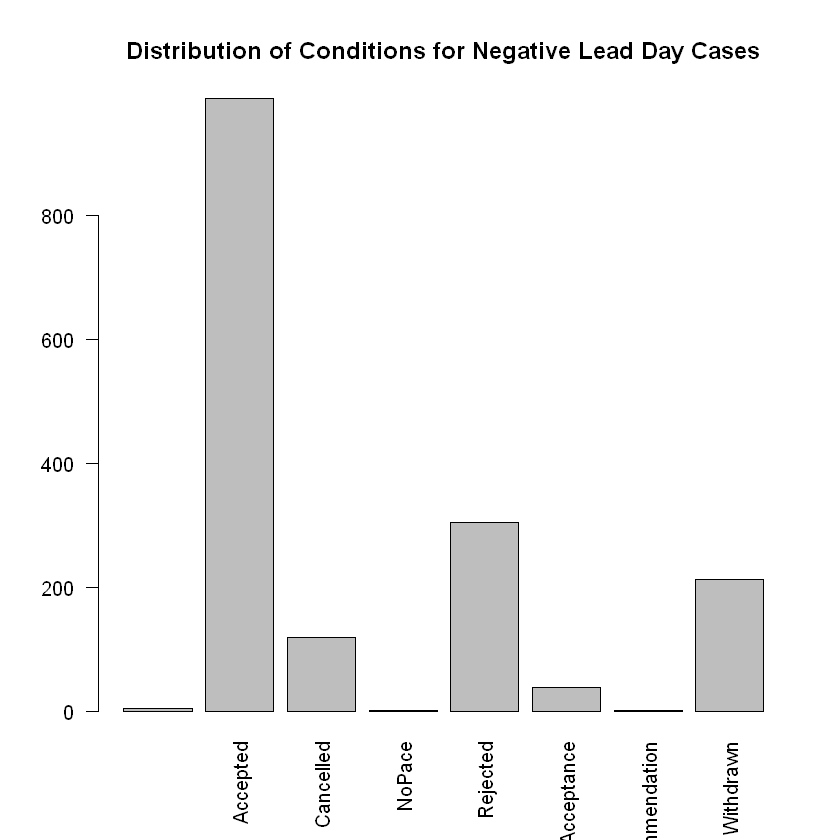

In [21]:
#Since we are on the topic of potential data issues, lets also take a look at
#lead days. The description says tht lead days  is the number of days between
#order placement and the pick up date. Given this description the value should't
#be negative but we know from the summary that this isn't the case.
#Perhaps if there was a case where there was a regular order that was delivered
#before it was placed? An order being anticipated as part of "Just in time?"
#How many of these cases are there?

nrow(data[data$lead_days <0,])

#as a percent

nrow(data[data$lead_days <0,])/nrow(data)

#It could be that 1% of the data are retroactive orders but I doubt it.
#Another possibility could be that all these orders are rejected/withdrawn/canceled
#and they are just human error. Lets check.

negativeLeadDaysSubset <- data[data$lead_days < 0,]
barplot(table(negativeLeadDaysSubset$CurrentCondition),las=2, main="Distribution of Conditions for Negative Lead Day Cases")

#While a good chunck of them are withdrawn, rejected, or canceled many more
#are accepted. Given this, these results these are not likely to be a data problem,
#just a documentation quirk for a specific kind of case.



In [22]:
#We know there are NA values from the summary function but lets do it again for the sake
# of thoroughness.
#This will give us a dataframe with the number of NAs in each column.
vectorOfNACounts <- lapply(data, function(y) sum(is.na(y)))
data.frame(vectorOfNACounts)

X,request_id,week_id,weekday,miles,order_equipment_type,order_distance,order_num_stops,order_origin_weight,lead_days,color,origin_dat_ref,dest_dat_ref,rate_norm,est_cost_norm,CurrentCondition
0,0,0,0,0,0,4678,0,19,0,0,0,0,181,39,0


        CurrentCondition
color          Accepted Cancelled NoPace Rejected Waiting On Acceptance
  GREEN     29    41312       604      7     1353                     7
  RED       81    40964      2503     47    33116                   721
  YELLOW     8    13889       281      0     2674                    72
        CurrentCondition
color    Waiting On Recommendation Withdrawn
  GREEN                         10      4118
  RED                           82     17043
  YELLOW                         3      2639

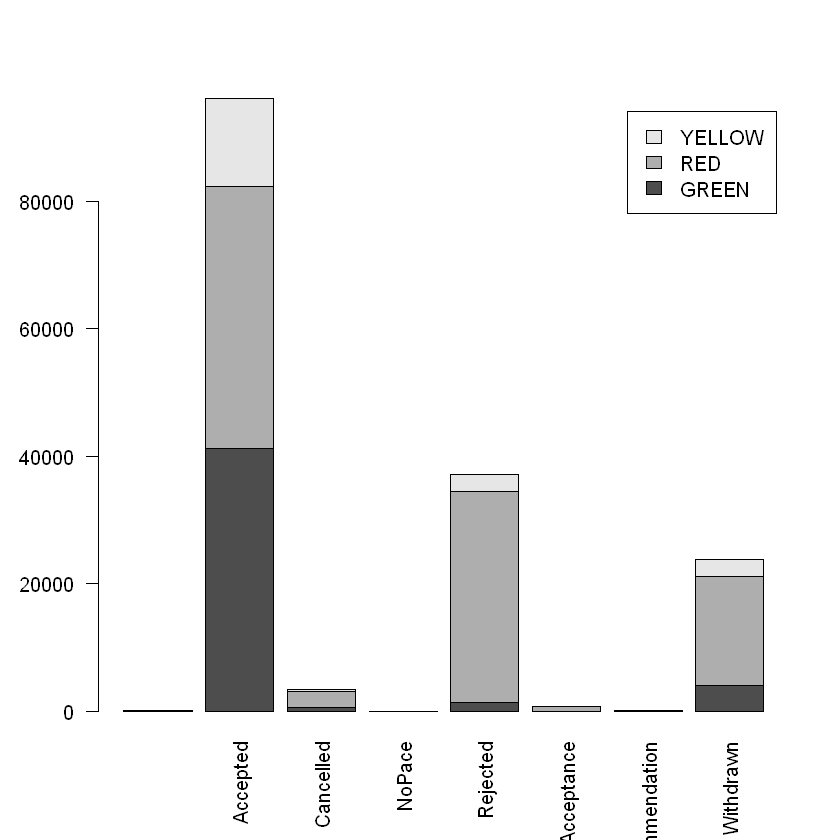

In [23]:
#Alright now for a quick check to confirm that color is 1:1 with CurrentCondition

justColorAndCondition <- data[,c("color","CurrentCondition")]
table(justColorAndCondition)

#Ok. Well that was off. Lets see a graph...

barplot(table(justColorAndCondition), legend = TRUE,las =2)

#Alright I don't think I am going to make much more progress without seeing overall correlations so lets take a look...

In [24]:
#This code is code that I used in my initial data exploration. It created a table
#that showed the correlation of all the variables against each other. Unfortunately,
#this package overwrites the versions other packages, specifically ones that caret
#requires to be unupdated in order to run in this version of R.

#   library(ggcorrplot)

#   #We are going to remove requestID, the NAs, and that duplicate from earlier

#   dataForDummified <- select(data, -request_id,-CurrentCondition)
#   dataForDummified <- na.omit(dataForDummified)
#   dataForDummified <- dataForDummified[-81224,]
#   dummifiedPredictor <- dummyVars("~ .", data=dataForDummified)
#   dummified <- data.frame(predict(dummifiedPredictor, newdata=dataForDummified))
#   correlations <- cor(dummified)
#   ggcorrplot(correlations)

[1] 0.7012936

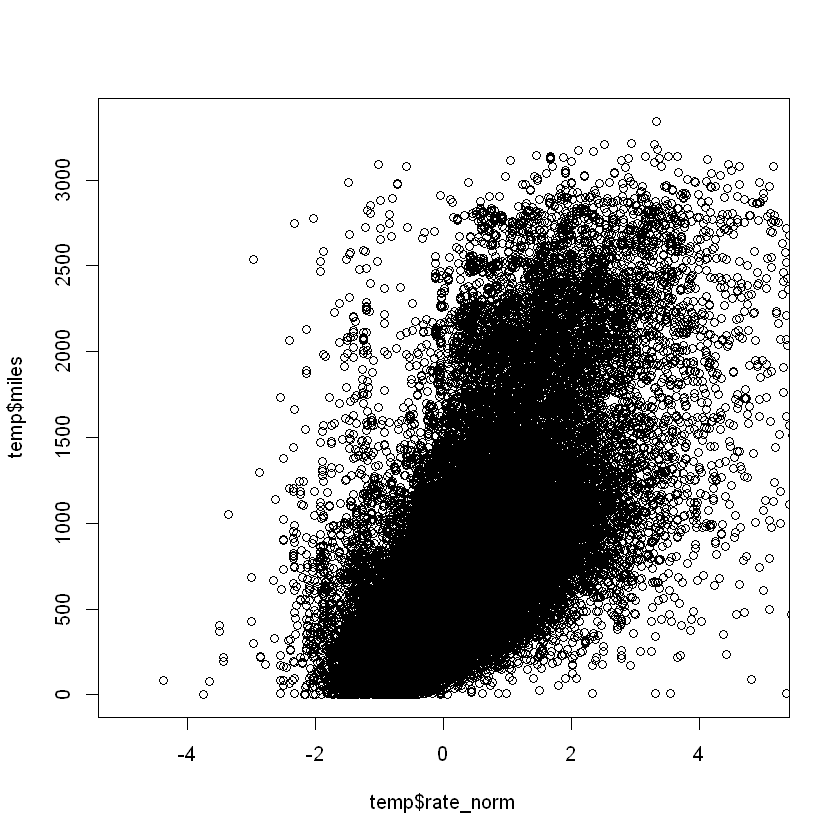

In [25]:
#Ok so we can see from this that the normalized rate and cost are both highly correlatedwith miles.
#To a much lesser degree, we can see that a higher rate_norm is correlated with Green status.
temp <- data
temp <- na.omit(temp)
cor(temp$miles,temp$rate_norm)
plot(temp$miles~temp$rate_norm, xlim= c(-5,5))
#You can see the clear correlation which is strong and positive.

[1] 0.7459502

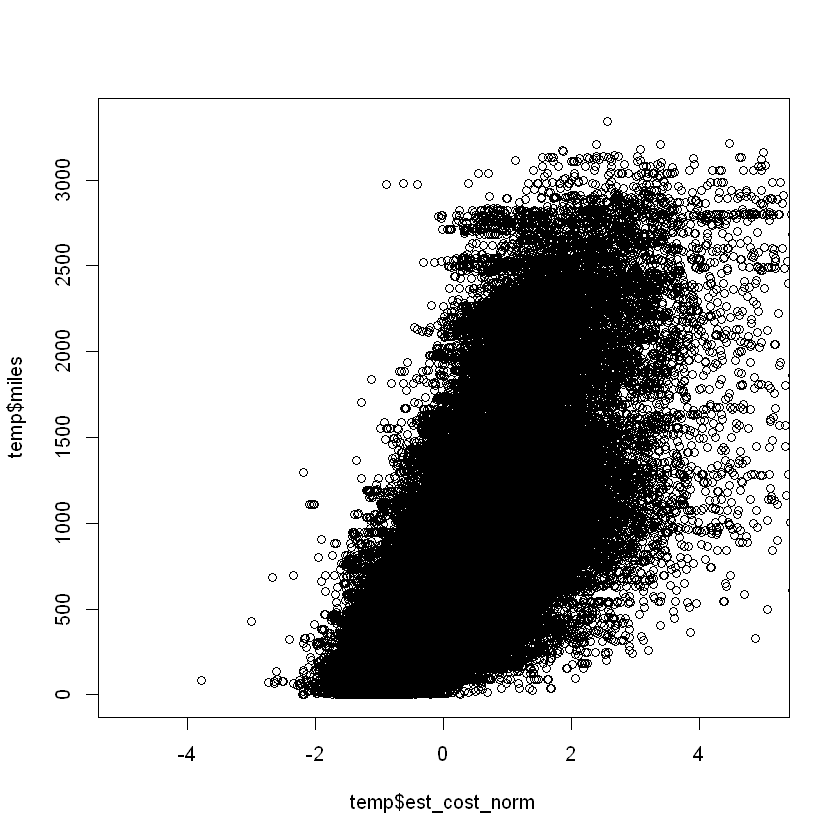

In [26]:
#Here is est_cost_norm and miles
cor(temp$miles,temp$est_cost_norm)
plot(temp$miles~temp$est_cost_norm, xlim= c(-5,5))

[1] 0.805135

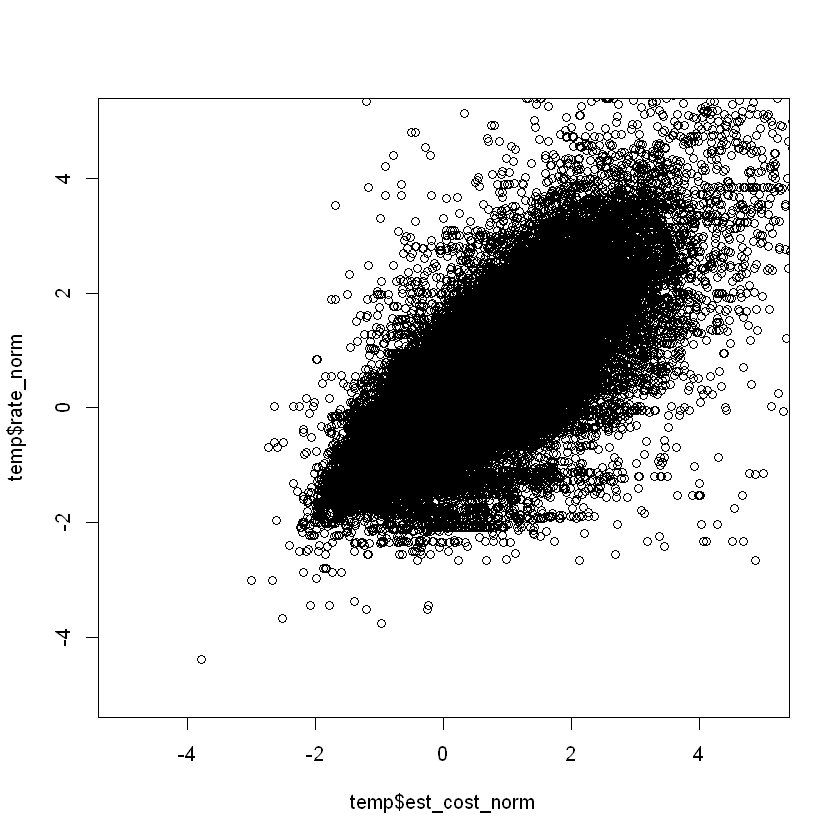

In [27]:
#Here is est_cost_norm and rate_norm... just curious
cor(temp$rate_norm,temp$est_cost_norm)
plot(temp$rate_norm~temp$est_cost_norm, xlim= c(-5,5),ylim=c(-5,5))

In [28]:
#I would also like to quickly check to see if there are any trends within the group of order_distance that are NA.
#Whats up with these?
naDistance <- data[is.na(data$order_distance),]
summary(naDistance)
#These seem pretty representative...

       X                                     request_id      week_id     
 Min.   :    40   00000bafac3f429fb206bc74e2d13a32:   1   Min.   :1.000  
 1st Qu.: 40023   000362bf8a1e4f6b9f767008f3dce956:   1   1st Qu.:1.000  
 Median : 78784   000594859005450f8a0ce061884ef87d:   1   Median :2.000  
 Mean   : 79749   001e1ca255524c778584e083f97e5f3f:   1   Mean   :2.392  
 3rd Qu.:119897   0025e83ad7554e2a91856eaafdaecdfe:   1   3rd Qu.:3.000  
 Max.   :161539   006f2b5694374454a55da8cfad00bd58:   1   Max.   :4.000  
                  (Other)                         :4672                  
 weekday        miles      order_equipment_type order_distance order_num_stops
 Fri: 846   Min.   :   1   R: 923               Min.   : NA    Min.   :2.000  
 Mon: 944   1st Qu.: 330   V:3755               1st Qu.: NA    1st Qu.:3.000  
 Sat:  33   Median : 642                        Median : NA    Median :3.000  
 Sun:  13   Mean   : 802                        Mean   :NaN    Mean   :3.063  
 Thu: 862   3

In [29]:
dataForModel <- select(data, -request_id,-X)
dataForModel <- na.omit(dataForModel)
dataForModel <- dataForModel[-81224,]
# Creating a reproducable test train split.
set.seed(555)
train_indexes <- createDataPartition(dataForModel$CurrentCondition,p=.9,times=1,list =FALSE)
trainSet <- dataForModel[train_indexes,]
testSet <- dataForModel[-train_indexes,]
trainY <- trainSet$CurrentCondition
trainX <- select(trainSet,-CurrentCondition)
trainXPredictor <- dummyVars("~ .", data=trainX)
trainXDummies <- as.data.frame(predict(trainXPredictor, newdata=trainX))
dataInput <- trainXDummies
dataInput$CurrentCondition <- as.factor(trainY)
#creating a control
control <- trainControl(method="repeatedcv", number = 5, repeats = 3)
#------------------------------------------------------------------------------------
#Actually creating the model, in this case a simple decision tree
#------------------------------------------------------------------------------------
treeMethod <- train(CurrentCondition~.,data=dataInput,method='rpart',trControl=control)
treeMethod

CART 

141022 samples
    22 predictor
     8 classes: '', 'Accepted', 'Cancelled', 'NoPace', 'Rejected', 'Waiting On Acceptance', 'Waiting On Recommendation', 'Withdrawn' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 3 times) 
Summary of sample sizes: 112816, 112816, 112819, 112818, 112819, 112818, ... 
Resampling results across tuning parameters:

  cp           Accuracy   Kappa     
  0.004114865  0.6254179  0.18584812
  0.004180808  0.6253163  0.18574425
  0.022306434  0.6044777  0.04568042

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.004114865.

In [30]:
#For this second model I have tried a few things. The methods I know for multiple outcome classification are decision Trees (boosted or otherwise)
# KNN (which isn't ideal because there can be many way ties and my computer can't handle the up front computational power needed to sort the data set),
# Naive Bayes (which I successfully ran with a result of .2 accuracy model and decided I could do better), Random Forest (which
# my computer also couldn't handle for a dataset this large). After rereading up on each I think that the best bet in this case is Gradient Boosting
# and that I should look carefully to make sure its not overfitting. However, since my computer is not great, I
# will run it on a small subset of the data.

set.seed(555)

#creating a smaller subset

dataTemp <- select(data,-request_id, -X)
dataTemp <- dataTemp[-81224,]
dataSmallIndex <- createDataPartition(dataTemp$CurrentCondition,p=.01,times=1,list = FALSE)
dataSmallTrain <- na.omit(dataTemp[dataSmallIndex,])
dataSmallTest <- na.omit(dataTemp[-dataSmallIndex,])

#identical control

control <- trainControl(method="repeatedcv", number = 5, repeats = 3)

In [31]:
#actually running a gradient boosted decision tree model
#-------------------------------------------------------------------
gradientBoosting <- train(CurrentCondition~., data = dataSmallTrain ,method='gbm',trControl=control,verbose = FALSE)
gradientBoosting

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: order_num_stops has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: order_num_stops has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: order_num_stops has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: order_num_stops has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: order_num_stops has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: order_num_stops has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: order_num_stops has no variation."Warnin

Stochastic Gradient Boosting 

1565 samples
  13 predictor
   8 classes: '', 'Accepted', 'Cancelled', 'NoPace', 'Rejected', 'Waiting On Acceptance', 'Waiting On Recommendation', 'Withdrawn' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 3 times) 
Summary of sample sizes: 1252, 1253, 1250, 1253, 1252, 1250, ... 
Resampling results across tuning parameters:

  interaction.depth  n.trees  Accuracy   Kappa    
  1                   50      0.6180905  0.1821782
  1                  100      0.6151316  0.2029470
  1                  150      0.6115047  0.2070756
  2                   50      0.6147071  0.2080525
  2                  100      0.6117081  0.2218667
  2                  150      0.6065948  0.2231738
  3                   50      0.6091671  0.2124141
  3                  100      0.6063893  0.2208280
  3                  150      0.6027616  0.2220426

Tuning parameter 'shrinkage' was held constant at a value of 0.1

Tuning parameter 'n.minobsinnode' was held co

In [32]:
#print the important variables for the simple decision tree
#-----------------------------------------------------------------
print("These are the variables chosen by the regular tree model in order of Importance.")
library(gbm)
varImp(treeMethod)

[1] "These are the variables chosen by the regular tree model in order of Importance."


rpart variable importance

  only 20 most important variables shown (out of 22)

                        Overall
color.RED              100.0000
color.GREEN             84.8222
order_origin_weight     34.3857
origin_dat_ref          28.8834
lead_days               16.0749
miles                   10.9875
order_distance           8.5899
color.YELLOW             4.9566
order_equipment_type.V   2.5342
order_equipment_type.R   2.5342
est_cost_norm            1.1021
dest_dat_ref             0.8157
weekday.Thu              0.6046
order_num_stops          0.0000
week_id                  0.0000
weekday.Wed              0.0000
weekday.Fri              0.0000
weekday.Sun              0.0000
rate_norm                0.0000
weekday.Sat              0.0000

In [33]:
#print the important variables for the boosted decision tree
#-----------------------------------------------------------------
print("These are the variables chosen by the gradient boosted tree model in order of Importance.")
library(gbm)
varImp(gradientBoosting)

[1] "These are the variables chosen by the gradient boosted tree model in order of Importance."


gbm variable importance

                       Overall
colorRED              100.0000
order_origin_weight    30.4943
origin_dat_ref         24.8245
dest_dat_ref           14.8896
lead_days              11.9259
rate_norm               9.0523
est_cost_norm           7.6220
miles                   5.9009
order_distance          4.6923
weekdayTue              3.6395
week_id                 1.8429
colorYELLOW             1.6925
weekdayMon              0.8545
order_equipment_typeV   0.4801
weekdaySun              0.4528
weekdayWed              0.0000
weekdayThu              0.0000
weekdaySat              0.0000
order_num_stops         0.0000

In [34]:
testY <- testSet$CurrentCondition
testX <- select(testSet, -CurrentCondition)
testXPredictor <- dummyVars("~ .",data=testX)
testXDummies <-as.data.frame(predict(testXPredictor, newdata=testX))
treePredictions <- predict(treeMethod,testXDummies)

library(irr)
kappa2(cbind(testY,treePredictions))

 Cohen's Kappa for 2 Raters (Weights: unweighted)

 Subjects = 15664 
   Raters = 2 
    Kappa = 0.194 

        z = 38.1 
  p-value = 0 

In [35]:
testY <- dataSmallTest$CurrentCondition
testX <- select(dataSmallTest, -CurrentCondition)
gradientPredictions <- predict(gradientBoosting,testX)

library(irr)
kappa2(cbind(testY,gradientPredictions))

 Cohen's Kappa for 2 Raters (Weights: unweighted)

 Subjects = 155121 
   Raters = 2 
    Kappa = 0.172 

        z = 102 
  p-value = 0 